In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from scipy.stats import skew, skewtest
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [ ]:
# Load dataset from the URL
dataset_url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_card_customers.csv"
dataset = pd.read_csv(dataset_url)

In [ ]:
# Dataset Structure
print(dataset.info())

# Dataset Shape
print(dataset.shape)

# Data Preview
print(dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

The dataset contains 8950 rows and 18 columns. As expected, most of the data are in float or integer formats. Only the CUST_ID column is of object type. Since CUST_ID is irrelevant for the analysis, I dropped it.

In [ ]:
# Drop CUST_ID column
dataset_new = dataset.drop(columns=['CUST_ID']) # this column is not useful for a clustering analysis

Subsequently, I checked the presence of missing values in the dataset.

In [ ]:
# Count missing values
missing_values = dataset_new.isna().sum()
print(missing_values)

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


Only the MINIMUM_PAYMENTS and CREDIT_LIMIT columns contain missing values.

In [ ]:
# Imputating missing values of CREDIT_LIMIT and MINIMUM_PAYMENTS columns with the mean values
dataset_new.CREDIT_LIMIT.fillna(dataset_new.CREDIT_LIMIT.mean(), inplace=True)
dataset_new.MINIMUM_PAYMENTS.fillna(dataset_new.MINIMUM_PAYMENTS.mean(), inplace=True)

In [ ]:
# Check again missing values
missing_values = dataset_new.isna().sum()
print("\nDataset Missing Values:")
print(missing_values)


Dataset Missing Values:
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


In [ ]:
# Checking for potential duplicate values
dataset_new.duplicated().sum()

0

#EXPLORATORY DATA ANALYSIS

In [ ]:
 # Descriptive Statistics of the variables
dataset_new.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


Already from this table, it is evident that the variables in the dataset are on different scales.

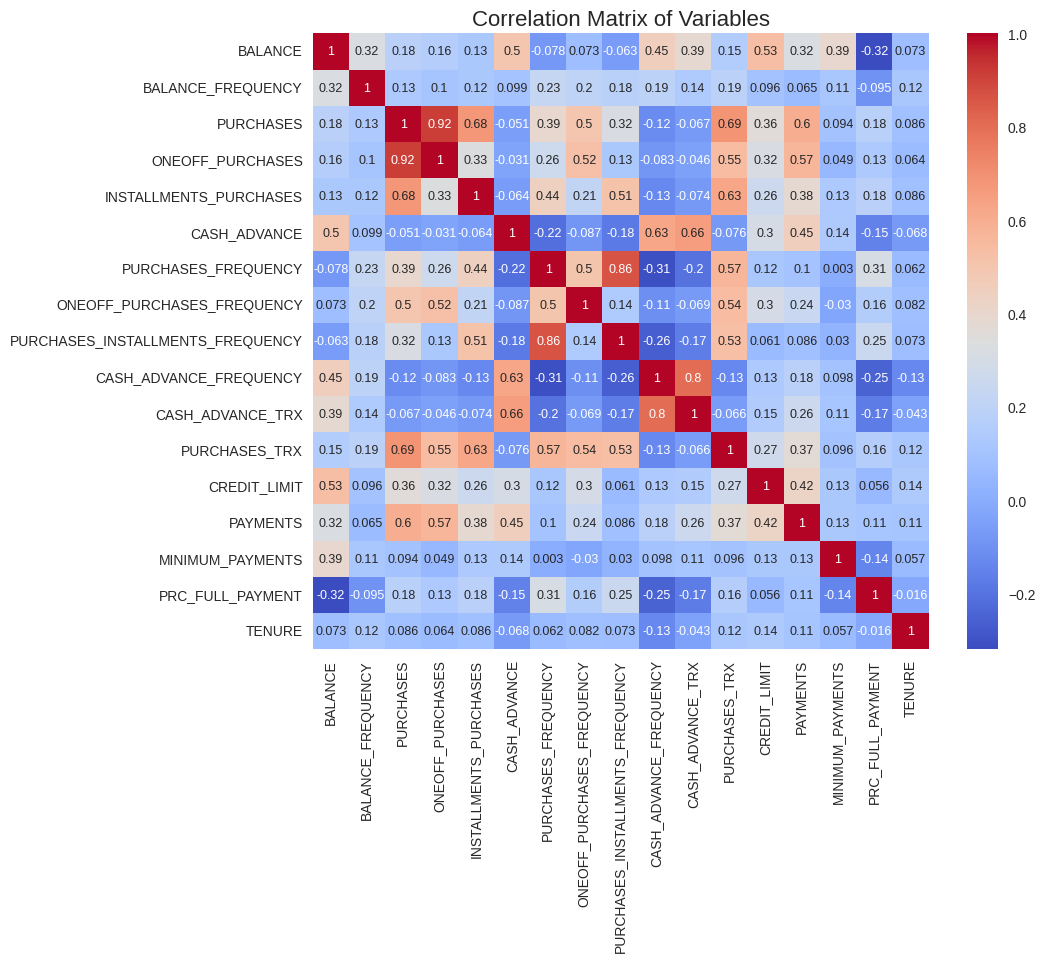

In [ ]:
# Calculate correlation matrix and create the heatmap
correlation_matrix = dataset_new.corr()

plt.figure(figsize=(10, 8))
hm = sns.heatmap(correlation_matrix,
                 cbar=True,
                 square=True,
                 annot=True,
                 annot_kws={'size':9},
                 cmap='coolwarm')

plt.title('Correlation Matrix of Variables', fontsize = 16)
plt.show()

MAIN FINDINGS:
- Very Strong Positive Correlation between PURCHASES and ONE_OFF_PURCHASES (r = 0.92) could indicate that when customers spend more in general, a significant portion of that spending is attributed to larger single purchases.

- Very Strong Positive Correlation between PURCHASES_FREQUENCY and PURCHASES_INSTALLMENT_FREQUENCY (r = 0.86) may indicate that customers who purchase frequently also tend to make planned and repetitive purchases, often paid in installments.

- Very Strong Positive Correlation between CASH_ADVANCE_FREQUENCY  and CASH_ADVANCE_TRX (r = 0.80) may indicate that customers who frequently use cash advances tend to make many such transactions.

- Strong Positive Correlation between CASH_ADVANCE_TRX and CASH_ADVANCE (r = 0.66) may indicate that a higher number of cash advance transactions is associated with a larger total value of advances.

- Strong Positive Correlation between PURCHASES_TRX and INSTALLMENTS_PURCHASES (r = 0.63) might suggest that customers who make many transactions also tend to make installment purchases.

- Strong Positive Correlation between PURCHASES and PURCHASES_TRX (r = 0.69) may indicate that customers who spend more on purchases also tend to make a higher number of purchase transactions.

- Positive Correlation between PAYMENTS and ONE_OFF_PURCHAES (r = 0.57) may indicate that as one-off purchases increase, so do the payments made. In other terms, that customers who make significant single purchases tend to pay more.

- Positive Correlation between CREDIT_LIMIT and BALANCE (r = 0.53) may imply that a higher credit limit is associated with a greater capacity for debt, though it doesn’t necessarily mean all customers with high credit limits use all available credit.

- Positive Correlation between PURCHASES_TRX and ONE_OFF_PURCHASES (r = 0.55)may indicate that customers making large single purchases tend to have a higher overall number of transactions.

- Positive Correlation between PURCHASES_TRX and PURCHASES_INSTALLMENT_FREQUENCY (r = 0.53) may suggest that customers who make more total purchases also tend to frequently use installment payments.

- Positive Correlation between PURCHAES_TRX and ONE_OFF_PURCHASES_FREQUENCY (r = 0.54) may suggest that customers with higher overall transaction counts balance between installment purchases and single transaction.

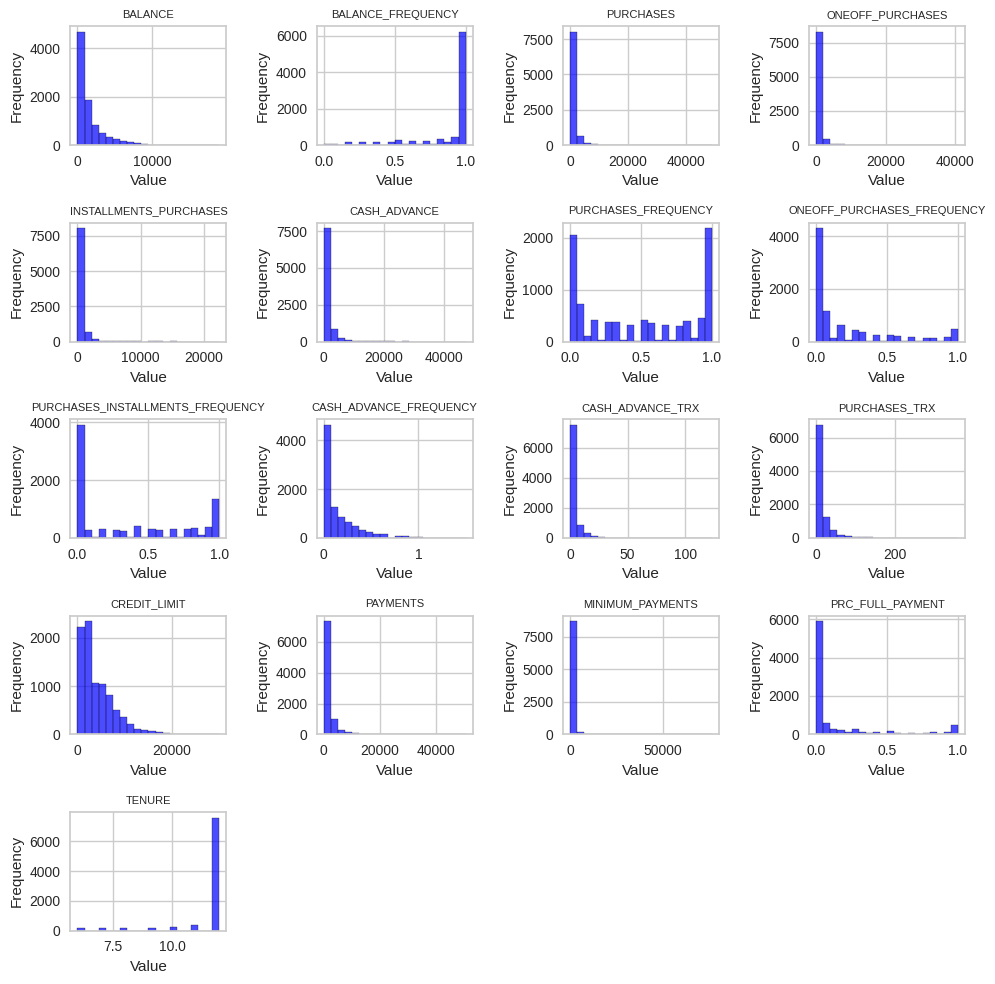

In [ ]:
# Create plots to see how data are distributed within variables
num_vars = dataset_new.shape[1]
num_rows, num_cols = 5, 4

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))
axs = axs.flatten()

# Loop through the variables and axes
for idx, ax in enumerate(axs):
    if idx < num_vars:
        ax.hist(dataset_new.iloc[:, idx], bins=20, alpha=0.7, color='blue', edgecolor='black')
        ax.set_title(dataset_new.columns[idx], fontsize=8)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    else:
        ax.axis('off')

# View Plot
plt.tight_layout()
plt.show()

KEY FINDINGS:

- Highly skewed distributions: Variables such as BALANCE, BALANCE_FREQUENCY, PURCHASES, ONE_OFF_PURCHASES, INSTALLMENTS_PURCHASES, CASH_ADVANCE, CASH_ADVANCE_FREQUENCY, CREDIT_LIMIT, MINIMUM_PAYMENTS, PAYMENTS, and PRC_FULL_PAYMENT exhibit highly skewed distributions with long tails. In these cases, most values are concentrated towards the lower end of the scale, while a few high values create long right tails.

- Multi-modal distributions: Only variables such as PURCHASES_FREQUENCY and PURCHASES_INSTALLMENTS_FREQUENCY show multi-modal distributions (i.e., distributions with multiple peaks). This could alreay indicate the presence of distinct groups of customers with different behaviors—e.g., those who purchase frequently versus those who purchase less often.

Overall, most of the variables in this dataset do not follow a normal distribution.

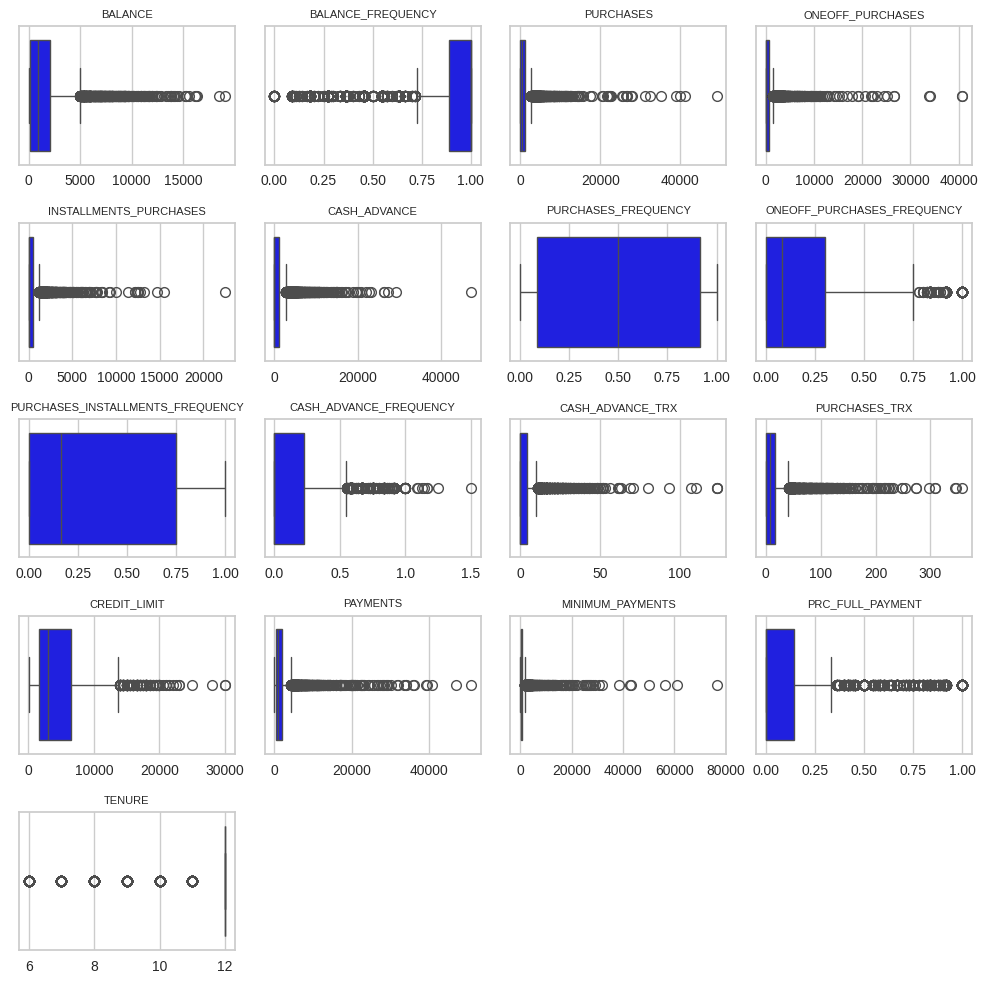

In [ ]:
# Plots to display outliers
plt.figure(figsize=(10, 10))

for i in range(len(dataset_new.columns)):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x=dataset_new[dataset_new.columns[i]], color='blue')
    plt.title(dataset_new.columns[i], fontsize=8)
    plt.xlabel('')
    plt.ylabel('')

# View plots
plt.tight_layout()
plt.show()

In [ ]:
# Calculate number of outliers
def find_outliers_all(dataset_new):
    outliers_dict = {}

    for feature in dataset_new.columns:
        print(f'Outliers for the variable "{feature}"')

        # Calculate Quartiles
        q1 = dataset_new[feature].quantile(0.25)
        q3 = dataset_new[feature].quantile(0.75)

        # Calculate IQR (Interquartile Range)
        iqr = q3 - q1
        limit = iqr * 1.5

        # Define lower and upper limits
        Lower_Limit = q1 - limit
        Upper_Limit = q3 + limit

        # Identify outliers
        outliers = dataset_new[(dataset_new[feature] < Lower_Limit) | (dataset_new[feature] > Upper_Limit)][feature]

        # Print information
        print(f'IQR: {iqr}')
        print(f'Lower Limit: {Lower_Limit}')
        print(f'Upper Limit: {Upper_Limit}')
        print(f'Number of outliers: {outliers.shape[0]}')
        print('_________________________')

        # Save outliers in a dictionary
        outliers_dict[feature] = outliers

    return outliers_dict


outliers = find_outliers_all(dataset_new)

Outliers for the variable "BALANCE"
IQR: 1925.85812
Lower Limit: -2760.5052645
Upper Limit: 4942.9272155
Number of outliers: 695
_________________________
Outliers for the variable "BALANCE_FREQUENCY"
IQR: 0.11111099999999996
Lower Limit: 0.7222225000000001
Upper Limit: 1.1666664999999998
Number of outliers: 1493
_________________________
Outliers for the variable "PURCHASES"
IQR: 1070.4950000000001
Lower Limit: -1566.1075000000003
Upper Limit: 2715.8725000000004
Number of outliers: 808
_________________________
Outliers for the variable "ONEOFF_PURCHASES"
IQR: 577.405
Lower Limit: -866.1075
Upper Limit: 1443.5124999999998
Number of outliers: 1013
_________________________
Outliers for the variable "INSTALLMENTS_PURCHASES"
IQR: 468.6375
Lower Limit: -702.95625
Upper Limit: 1171.59375
Number of outliers: 867
_________________________
Outliers for the variable "CASH_ADVANCE"
IQR: 1113.8211392500002
Lower Limit: -1670.7317088750003
Upper Limit: 2784.5528481250003
Number of outliers: 1030


Most of the variables exhibit significant outliers that need to be considered in the context of clustering analysis.

#DATA PREPROCESSING

In [ ]:
# Use Power Transformer to reduce skewness of variables
power_transformer = PowerTransformer()
dataset_transformed = power_transformer.fit_transform(dataset_new)

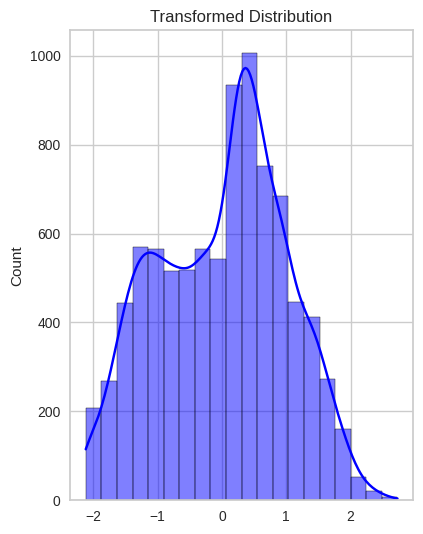

In [ ]:
# Check again data distribution to see if it is normal
plt.subplot(1, 2, 2)
sns.histplot(dataset_transformed[:, 0], bins=20, kde=True, color = 'blue')
plt.title('Transformed Distribution')

plt.tight_layout()
plt.show()

Even though the data does not follow a perfect normal distribution, the skewness has been significantly reduced. The transformed data is more symmetrically distributed around the mean, which should improve the performance of algorithms that assume normality as PCA.

In [ ]:
# Scaling the dataset using Standard Scaler
scaler = StandardScaler()
standardized_dataset = scaler.fit_transform(dataset_transformed) # to standardize data

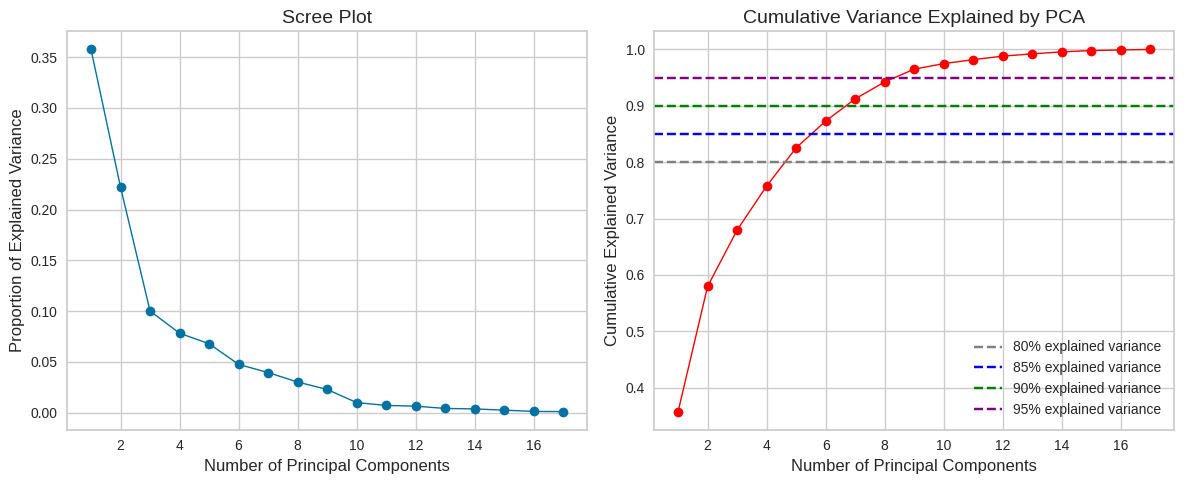

In [ ]:
# PCA on the standardized dataset
pca = PCA().fit(standardized_dataset)

# Cumulative Variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Scree plot size
plt.figure(figsize=(12, 5))

# Scree plot with cumulative variance of variables
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(cumulative_variance) + 1), pca.explained_variance_ratio_, 'o-', linewidth=1)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Proportion of Explained Variance', fontsize=12)
plt.title('Scree Plot', fontsize=14)
plt.grid(True)

# Cumulative variance explained
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', linewidth=1, color='red')
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Variance Explained by PCA', fontsize=14)
plt.axhline(y=0.80, color='gray', linestyle='--', label='80% explained variance')
plt.axhline(y=0.85, color='blue', linestyle='--', label='85% explained variance')
plt.axhline(y=0.90, color='green', linestyle='--', label='90% explained variance')
plt.axhline(y=0.95, color='purple', linestyle='--', label='95% explained variance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Apply PCA with number of 5 components to keep around 80% of the variance
n_components_to_keep = 5

pca = PCA(n_components=n_components_to_keep)
pca_data = pca.fit_transform(standardized_dataset)

# Calculate ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance of first {n_components_to_keep} components: {explained_variance}")
print(f"Cumulative variance: {sum(explained_variance)}")

Explained variance of first 5 components: [0.35768855 0.22200793 0.0999918  0.07809073 0.06779601]
Cumulative variance: 0.8255750132936814


In [ ]:
# Calculate skewness of each principal component
pca_skewness = np.abs(skew(pca_data))
print("Skewness of principal components:")
print(pca_skewness)

# Calculate p-values of each principal component
_, pc_pvalues = skewtest(pca_data)
print("P-values of princial components:")
print(pc_pvalues)

Skewness of principal components:
[0.24696417 0.16895269 0.15060187 0.16675977 0.7110501 ]
P-values of princial components:
[5.11885228e-021 8.86447314e-011 7.08101608e-009 1.53239921e-010
 2.90903164e-136]



- Skewness: The skewness values are relatively higher, especially for the fifth component (0.711), indicating that the data after PCA is quite skewed and far from a normal distribution.
- P-values: The p-values are extremely small, which strongly suggests that the principal components are not normally distributed.

In [ ]:
# Apply Power Transformer to reduce skewness
power_transformer = PowerTransformer()
pca_data_transformed = power_transformer.fit_transform(pca_data)

In [ ]:
# Calculate again skewness each principal component
pca_skewness = np.abs(skew(pca_data_transformed))
print("Skewness of principal components:")
print(pca_skewness)

# Calculate again p-values of principal components
_, pc_pvalues = skewtest(pca_data_transformed)
print("P-values of principal components:")
print(pc_pvalues)

Skewness of principal components:
[0.00635665 0.02550448 0.01831497 0.03454566 0.06187109]
P-values of principal components:
[0.80590672 0.32428014 0.47901052 0.1818944  0.01687993]


- Skewness: The skewness values are now closer to zero, with the largest being 0.0618 for the fifth component. This indicates that the data is now far more symmetrical and better aligned with a normal distribution.
- P-values: The p-values have also significantly improved. Most of the components now have p-values above 0.05, which suggests that they do not significantly deviate from normality. Only the fifth component has a p-value slightly below 0.05 (0.0169), but it's still much better than before.


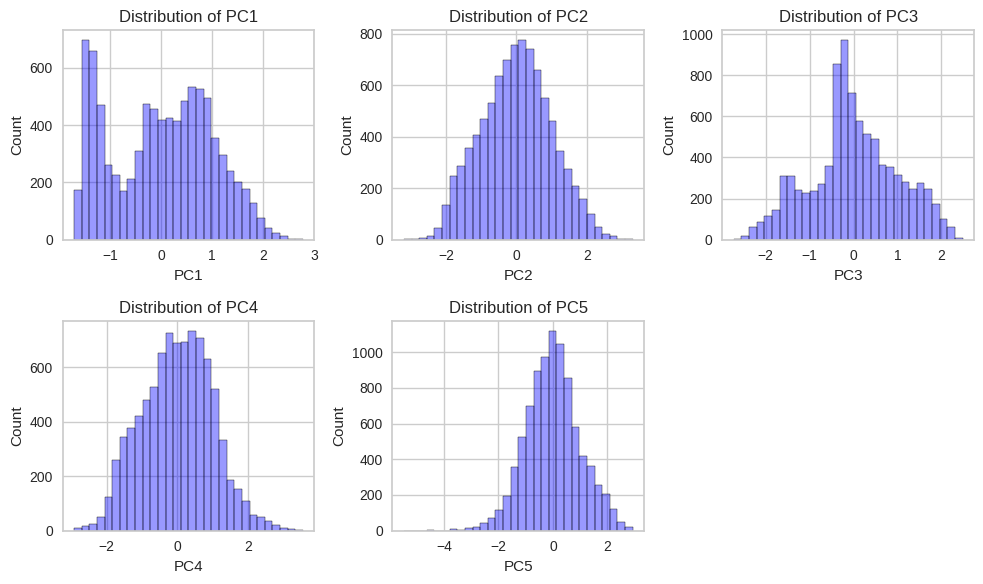

In [ ]:
# Plot to check normal distribution
pca_var_distribution = pd.DataFrame(pca_data_transformed,
                                    columns=[f'PC{i+1}' for i in range(n_components_to_keep)])

plt.figure(figsize=(10, 6))

for i in range(n_components_to_keep):
    plt.subplot(2, 3, i+1)
    sns.histplot(pca_var_distribution[f'PC{i+1}'], bins=30, color='blue', alpha = 0.4)
    plt.title(f'Distribution of PC{i+1}', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Scaling again the dataset after PCA using Standard Scaler
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data_transformed)

#CLUSTERING ANALYSIS WITH K-MEANS

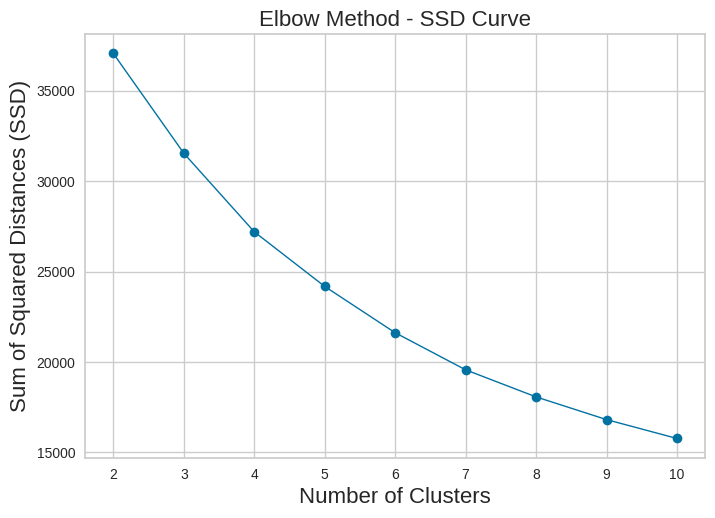

In [ ]:
# Implementing Elbow Method to determine number of clusters

RANDOM_SEED = 0

clusters = range(2, 11)
scores = []

for n in clusters:
    cluster = KMeans(n_clusters=n, init="k-means++", random_state=RANDOM_SEED, n_init=10)
    pred = cluster.fit_predict(pca_data_scaled)
    score = cluster.inertia_
    scores.append(score)

plt.plot(clusters, scores, marker='o', linewidth = 1)
plt.plot(marker='o', linewidth=1)
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Sum of Squared Distances (SSD)", fontsize=16)
plt.title("Elbow Method - SSD Curve", fontsize=16)
plt.grid(True)

The Elbow Method seems to suggest that 4 or 5 may be the optimal number of clusters. However, it is interesting to evaluate other clustering metrics to ensure that this choice of clusters truly balances the quality of the clustering.

Hence, I will also look at:

- Silhouette Score: A higher silhouette score (closer to 1) indicates that clusters are well-separated and cohesive.
- Davies-Bouldin Index: Lower values indicate better clustering, as it represents the average ratio of within-cluster scatter to between-cluster separation.
- Calinski-Harabasz Index: A higher score implies better-defined clusters.

In [ ]:
# Function to evaluate different numbers of clusters using other metrics
def evaluate_different_clusters(pca_data_scaled, max_clusters=10):
    results = []

    for n_clusters in range(2, max_clusters + 1):
        cluster = KMeans(n_clusters=n_clusters, init="k-means++", random_state=RANDOM_SEED, n_init=10)
        labels = cluster.fit_predict(pca_data_scaled)

        sil_score = silhouette_score(pca_data_scaled, labels)
        db_score = davies_bouldin_score(pca_data_scaled, labels)
        ch_score = calinski_harabasz_score(pca_data_scaled, labels)

        results.append({
            "n_clusters": n_clusters,
            "silhouette_score": sil_score,
            "davies_bouldin_index": db_score,
            "calinski_harabasz_index": ch_score,
        })

    return pd.DataFrame(results)

results_clusters = evaluate_different_clusters(pca_data_scaled, max_clusters=10)
print(results_clusters)

   n_clusters  silhouette_score  davies_bouldin_index  calinski_harabasz_index
0           2          0.184255              2.112746              1856.361230
1           3          0.213656              1.708924              1873.140516
2           4          0.232610              1.548571              1924.379257
3           5          0.234443              1.390571              1903.081334
4           6          0.248137              1.287170              1914.658448
5           7          0.258522              1.254555              1919.118297
6           8          0.256956              1.210956              1887.038959
7           9          0.256696              1.213319              1857.761215
8          10          0.248762              1.197311              1826.373196


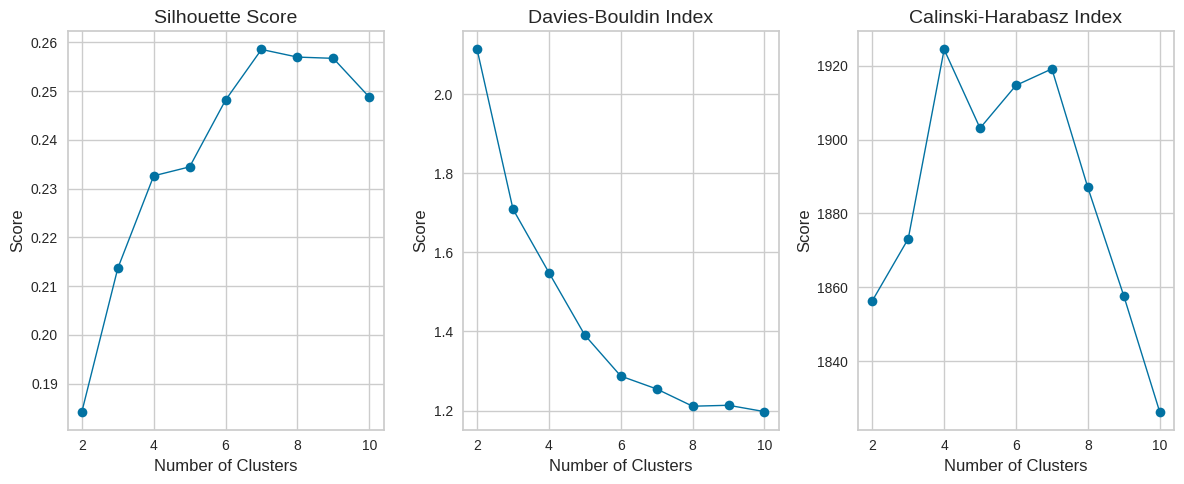

In [ ]:
# Plot the results for each metric
def plot_clustering_results(results_df):
    clusters = results_df['n_clusters']

    plt.figure(figsize=(12, 5))

    # Plot Silhouette Score
    plt.subplot(1, 3, 1)
    plt.plot(results_clusters['n_clusters'], results_clusters['silhouette_score'], marker='o', linewidth=1)
    plt.title('Silhouette Score', fontsize=14)
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.grid(True)

    # Plot Davies-Bouldin Index
    plt.subplot(1, 3, 2)
    plt.plot(results_clusters['n_clusters'], results_clusters['davies_bouldin_index'], marker='o', linewidth=1)
    plt.title('Davies-Bouldin Index', fontsize=14)
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.grid(True)

    # Plot Calinski-Harabasz Index
    plt.subplot(1, 3, 3)
    plt.plot(results_clusters['n_clusters'], results_clusters['calinski_harabasz_index'], marker='o', linewidth=1)
    plt.title('Calinski-Harabasz Index', fontsize=14)
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_clustering_results(results_clusters)

After evaluating the four parameters, I will opt for 5 clusters for the following reasons:

- Silhouette Score: Although the score continues to rise beyond 5 clusters, reaching its maximum with 7, the difference between 5 and 7 clusters is relatively small. Adding more clusters does not significantly improve the score.
- Davies-Bouldin Index: While the lowest value is reached around 8 clusters, indicating better separation between clusters, the differences beyond 5 clusters are not substantial enough to justify additional complexity.
- Calinski-Harabasz Index: Peaks at 4 clusters, indicating a well-defined clustering structure at this point.

Even though both the Silhouette Score and Davies-Bouldin Index show slight improvements beyond 5 clusters, 5 clusters provide a balance between simplicity and performance without losing significant clustering quality.

In [ ]:
# Apply K-Means with 5 cluster
cluster = KMeans(n_clusters=5, init="k-means++", random_state=RANDOM_SEED, n_init=10)
labels = cluster.fit_predict(pca_data_scaled)

# Centroids of clusters
centroids = cluster.cluster_centers_
print(f"Centroids of 5 clusters:\n {centroids}")

Centroids of 5 clusters:
 [[-0.34897141  0.74922509 -0.05257602  0.71413239  0.99376756]
 [ 0.46452377  0.09777931  0.88172508 -0.9960342   0.3080135 ]
 [ 0.8210753  -0.46389899  0.64784519  0.85944618 -0.82831799]
 [-1.24872233  0.19863935 -0.18557004 -0.15193563 -0.67691055]
 [ 0.55393736 -0.73670407 -1.24331981 -0.27911762  0.05709214]]


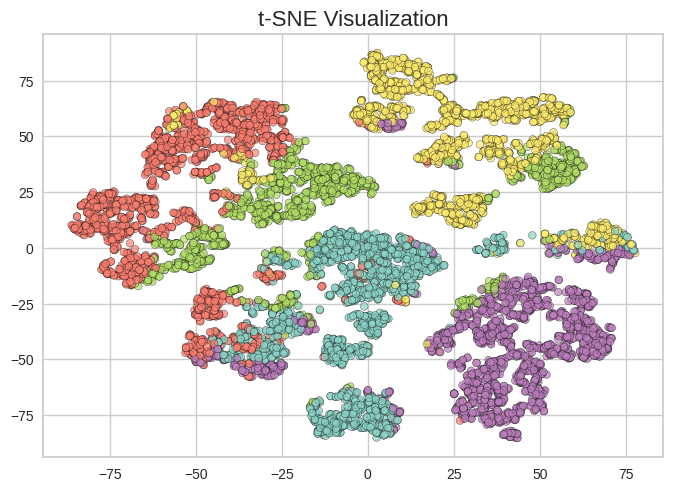

In [ ]:
# Apply TSN to see distribution of clusters
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
data_tsne = tsne.fit_transform(pca_data_scaled)

# Plot results
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], alpha = 0.7, c=labels, cmap='Set3', s=30,edgecolor = "black")
plt.title('t-SNE Visualization', fontsize = 16)
plt.show()

The t-SNE visualization confirms a quite good separation of the 5 clusters identified by the K-Means algorithm. While there are some slight overlaps, this is expected given that high-dimensional data is projected into a two-dimensional space. Despite these overlaps, the visualization suggests that K-Means has effectively captured some distinct customer segments, offering a reliable representation of the underlying structure in the data.

# FINAL CONSIDERATIONS

In [ ]:
# Create dataset with clusters
dataset_final = pd.DataFrame(dataset_new, columns=dataset_new.columns)

# Add Cluster labels
dataset_final['Cluster'] = labels
print(dataset_final.head())

       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                

In [ ]:
# Count number of observations per cluster
cluster_sizes = dataset_final['Cluster'].value_counts()
cluster_sizes = cluster_sizes.sort_index()
print("Number of consumers in each group:\n", cluster_sizes)

Number of consumers in each group:
 Cluster
0    1893
1    1872
2    1506
3    1933
4    1746
Name: count, dtype: int64


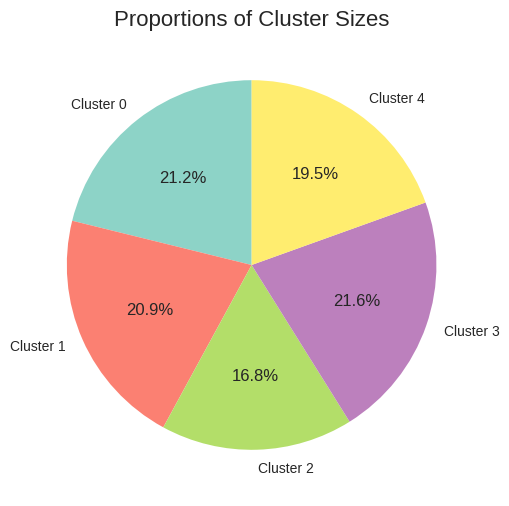

In [ ]:
# Plot Pie Chart
labels = [f'Cluster {i}' for i in cluster_sizes.index]

plt.figure(figsize=(6, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(cluster_sizes)))
plt.pie(cluster_sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Proportions of Cluster Sizes', fontsize = 16)
plt.show()

The number of people within clusters seems to be equally distributed in terms of proportions.

In [ ]:
# Visualize statistics
cluster_statistics = dataset_final.groupby('Cluster').mean().transpose()
print(cluster_statistics)

Cluster                                     0            1            2  \
BALANCE                           2393.209741  1541.704938   303.339598   
BALANCE_FREQUENCY                    0.916859     0.907854     0.717262   
PURCHASES                         1127.906307  1466.274941  1993.116607   
ONEOFF_PURCHASES                   697.032367  1059.282618  1292.968499   
INSTALLMENTS_PURCHASES             430.885679   407.220892   700.561122   
CASH_ADVANCE                      2220.015076    53.066473   173.860780   
PURCHASES_FREQUENCY                  0.525971     0.544588     0.600173   
ONEOFF_PURCHASES_FREQUENCY           0.271067     0.386467     0.359500   
PURCHASES_INSTALLMENTS_FREQUENCY     0.374165     0.299709     0.403589   
CASH_ADVANCE_FREQUENCY               0.327272     0.012072     0.015006   
CASH_ADVANCE_TRX                     8.027998     0.184829     0.295485   
PURCHASES_TRX                       18.025885    20.091346    22.391766   
CREDIT_LIMIT             

**CLUSTER 0**
- Users with high balances and significant use of cash advances, probably relying heavily on credit and requiring frequent liquidity. However, they tend not to pay off their balances in full, which could indicate a risk of default.

**CLUSTER 1**
- Users who spend a lot on their cards but rarely use cash advances. Despite their spending, they tend not to fully pay off their balance, which could signal potential financial risk.

**CLUSTER 2**
- Users with low balances, high spending, and financially responsible behavior, as over half of them fully pay their balance. They likely have a high credit availability and tend to manage their finances well.

**CLUSTER 3**
- Users who primarily use credit card for cash advances, with high balances and very low purchases. They don’t fully pay their balance, which could indicate a default risk. These users are more inclined to take cash rather than make purchases.

**CLUSTER 4**
- Users with low balances, moderate spending, and moderately responsible payment behavior. They are likely regular card users but with lower credit limits than other clusters.

**SUGGESTIONS FOR A MARKETING STRATEGY:**
- Invest in **CLUSTER 2**: This is the most promising group for generating revenue while ensuring financial stability. Offering them premium products and exclusive loyalty programs can increase their spending and strengthen long-term loyalty.

- Monitor **CLUSTER 0 and CLUSTER 3**: These clusters represent financial risk, so it’s better to offer them debt management solutions rather than spending incentives.

- Incentivize **CLUSTER 1** and **CLUSTER 4**: These users already spend a lot (Cluster 1) or have the potential to grow (Cluster 4). They can be offered rewards and promotions to be encourage to use their cards more frequently and pay off their balances more regularly.

